In [1]:
import numpy as np
import tifffile as tiff
from math import sqrt
from skimage.transform import resize
import sys
import cv2
import numpy as np
import cv2
import glob
import random
from matplotlib.image import imsave
import mahotas as mh
from scipy import ndimage
from skimage.measure import regionprops
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid", {'axes.grid' : False})
%matplotlib inline


/apps/well/python/3.4.6-gcc4.8.2/lib/python3.4/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
import pandas as pd

test_tiles=pd.read_csv('/well/lindgren/craig/isbi-2012/tile.predictionsClassifer.csv')
test_tiles.head()


,image,empty,not_adipocyte,adipocyte,Max,sampleID,depot
0,29696-12288_GTEX-16NFA_Visceral-Omentum.jpg,0.988032,0.010689,0.001279,empty,GTEX-16NFA,Visceral-Omentum
1,16384-2048_GTEX-14PJ4_Adipose-Subcutaneous.jpg,0.991265,0.005236,0.003499,empty,GTEX-14PJ4,Adipose-Subcutaneous
2,5120-7168_GTEX-12WSC_Visceral-Omentum.jpg,0.986777,0.011543,0.001680,empty,GTEX-12WSC,Visceral-Omentum
3,4096-15360_GTEX-VJWN_Adipose-Subcutaneous.jpg,0.971102,0.026484,0.002415,empty,GTEX-VJWN,Adipose-Subcutaneous
4,28672-24576_GTEX-WYVS_Visceral-Omentum.jpg,0.981454,0.015462,0.003084,empty,GTEX-WYVS,Visceral-Omentum


In [3]:
adipocyte_tiles = test_tiles[test_tiles['adipocyte'] > 0.60]
print('Total number of adipocyte containing tiles: {}'.format(len(adipocyte_tiles)))

Total number of adipocyte containing tiles: 236443


In [40]:
adipocyte_tiles=adipocyte_tiles.sort_values('image')
adipocyte_tiles.head()

,image,empty,not_adipocyte,adipocyte,Max,sampleID,depot
2014499,0-10240_GTEX-13QJC_Adipose-Subcutaneous.jpg,0.024485,0.046475,0.929040,adipocyte,GTEX-13QJC,Adipose-Subcutaneous
906079,0-10240_GTEX-RWSA_Adipose-Subcutaneous.jpg,0.258609,0.046165,0.695227,adipocyte,GTEX-RWSA,Adipose-Subcutaneous
670966,0-11264_GTEX-13QJC_Adipose-Subcutaneous.jpg,0.031643,0.076135,0.892222,adipocyte,GTEX-13QJC,Adipose-Subcutaneous
802733,0-11264_GTEX-RWSA_Adipose-Subcutaneous.jpg,0.007635,0.015629,0.976736,adipocyte,GTEX-RWSA,Adipose-Subcutaneous
127113,0-12288_GTEX-13QJC_Adipose-Subcutaneous.jpg,0.006981,0.003391,0.989628,adipocyte,GTEX-13QJC,Adipose-Subcutaneous


In [5]:
seg_masks = sorted(glob.glob('predicted_masks/*.png'))
seg_masks[0:5]

['predicted_masks/Pred_Mask_0-10240_GTEX-13QJC_Adipose-Subcutaneous.png',
 'predicted_masks/Pred_Mask_0-10240_GTEX-RWSA_Adipose-Subcutaneous.png',
 'predicted_masks/Pred_Mask_0-11264_GTEX-13QJC_Adipose-Subcutaneous.png',
 'predicted_masks/Pred_Mask_0-11264_GTEX-RWSA_Adipose-Subcutaneous.png',
 'predicted_masks/Pred_Mask_0-12288_GTEX-13QJC_Adipose-Subcutaneous.png']

In [6]:
# count cells and measure their areas from the stored, predicted, segmentation masks.
def predict_areas(input_img,mu=False,no=False):
    labels, no_objects = ndimage.label(input_img)
    labelled=ndimage.label(input_img)
    resh_labelled=labelled[0].reshape((input_img.shape[0],input_img.shape[1])) #labelled is a tuple: only the first element matters
    props=regionprops(resh_labelled) 
    size={i:props[i].area for i in range (0, no_objects)}
    no_of_cells=(sum(i > 500 and i < 50000 for i in size.values()))
    areas=[i for i in size.values() if i >= 500 and i <= 70000]
    areas=np.array(areas) * 0.495
    if mu and no:
        return(areas,np.mean(areas),no_of_cells)
    elif mu:
        return(areas,np.mean(areas))
    else:
        return(areas)


In [9]:
# example prediction

ex_img = cv2.imread(seg_masks[0],0)

cell_areas,mu_area,no_cells = predict_areas(ex_img,mu=True,no=True)

print('Average adipocyte area for this tile is {0:.1f}um and number of\
 cells present is {1:}'.format(mu_area,no_cells))


Average adipocyte area for this tile is 8210.1um and number of cells present is 50


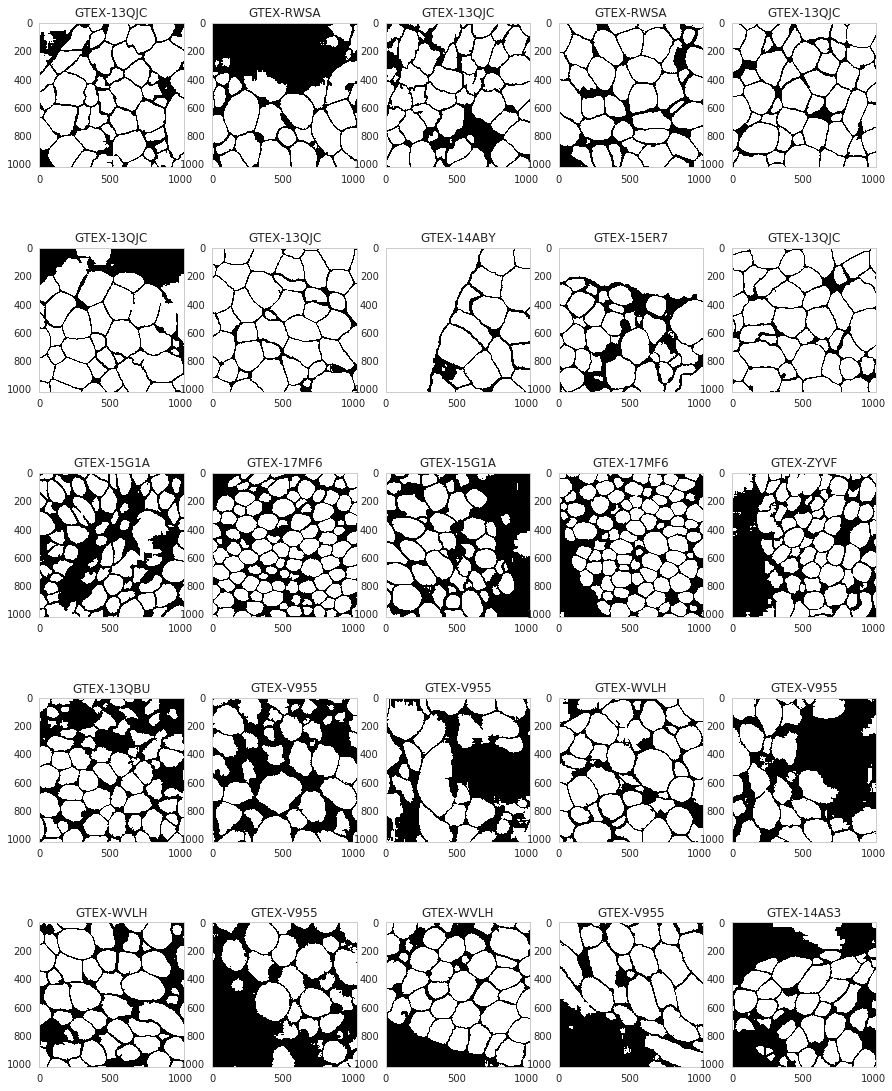

In [10]:
def plot_me(img_list):
    plt.rcParams["font.family"] = "DejaVu Sans"
    i = 1
    fig = plt.figure(figsize=(15,20))
    for r in img_list:
        ax = fig.add_subplot(5,5,i)
        ax.grid(b="off")
        i+=1
        plt.imshow(plt.imread(r))
        plt.title('%s'%r.split('/')[1].split('_')[3])

# example segmentation masks - majority are high quality. False segmentations such as background are filtered out -
# For some poor quality tiles (H&E dye failed) segmentations will also be bad - will assess suitable threshold.
plot_me(seg_masks[0:25])

/apps/well/python/3.4.6-gcc4.8.2/lib/python3.4/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


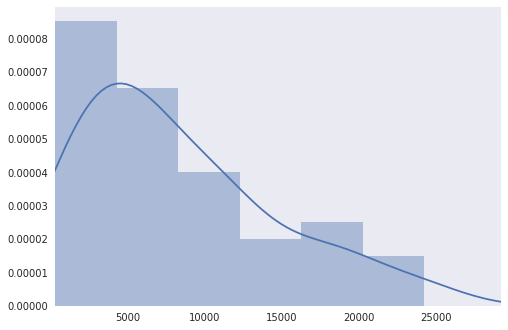

In [11]:
sns.set(); 
ax = sns.distplot(cell_areas)
ax.set(xlim=(round(np.min(cell_areas)), np.max(cell_areas)+5000))
ax.grid(False)
plt.show()


In [12]:
# This sample below had the highest number of adipocyte tiles classified (664!)
# Lets look at those segmentation masks
max_sample = adipocyte_tiles[adipocyte_tiles['sampleID'] == 'GTEX-1GF9V']
max_sample = max_sample[max_sample['depot'] == 'Visceral-Omentum']


In [13]:
print(max_sample.head())
len(max_sample)

                                               image     empty  not_adipocyte  \
1887273  10240-13312_GTEX-1GF9V_Visceral-Omentum.jpg  0.033749       0.272208   
417211   10240-14336_GTEX-1GF9V_Visceral-Omentum.jpg  0.017539       0.057184   
830984   10240-15360_GTEX-1GF9V_Visceral-Omentum.jpg  0.050794       0.249901   
1619633  11264-13312_GTEX-1GF9V_Visceral-Omentum.jpg  0.014528       0.041356   
1347499  11264-14336_GTEX-1GF9V_Visceral-Omentum.jpg  0.009372       0.019111   

         adipocyte        Max    sampleID             depot  
1887273   0.694043  adipocyte  GTEX-1GF9V  Visceral-Omentum  
417211    0.925277  adipocyte  GTEX-1GF9V  Visceral-Omentum  
830984    0.699305  adipocyte  GTEX-1GF9V  Visceral-Omentum  
1619633   0.944116  adipocyte  GTEX-1GF9V  Visceral-Omentum  
1347499   0.971517  adipocyte  GTEX-1GF9V  Visceral-Omentum  


664

In [14]:
max_masks = ['predicted_masks/Pred_Mask_'+i.split('.')[0]+'.png' for i in max_sample['image'].tolist()]

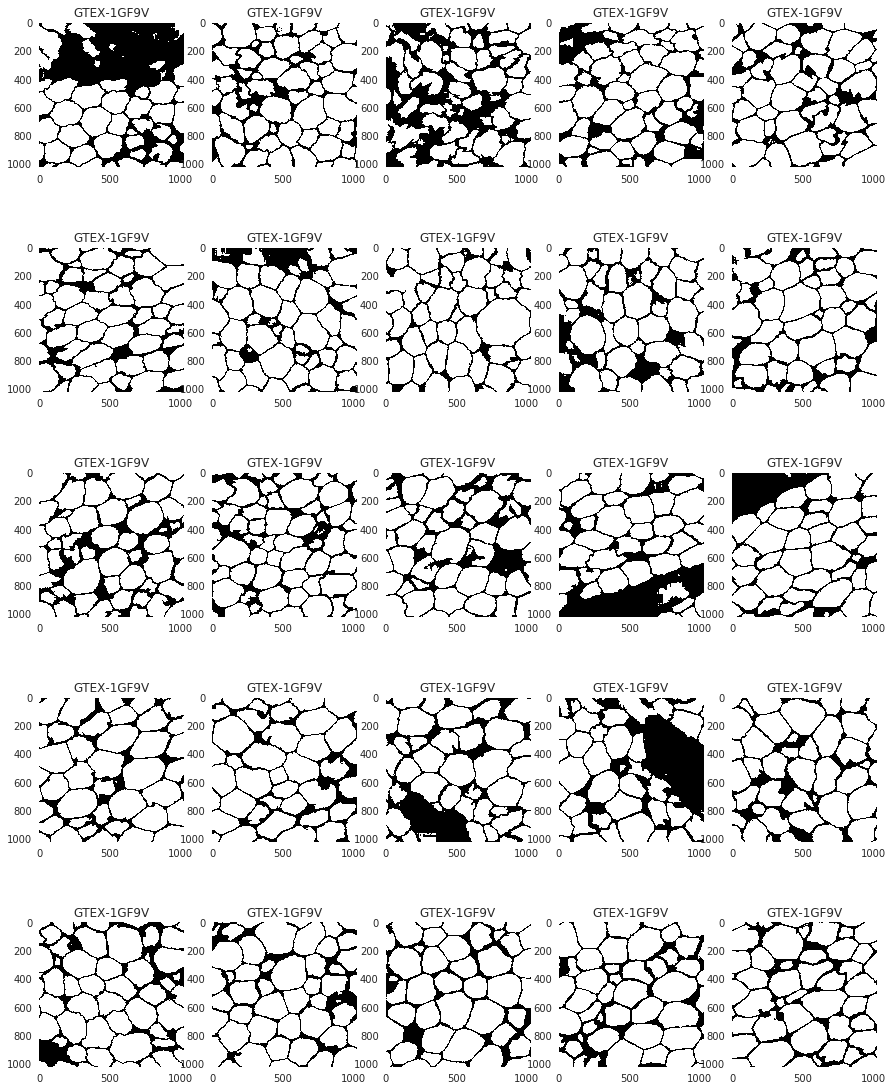

In [15]:
plot_me(max_masks[0:25])

In [16]:
from tqdm import tqdm

In [17]:
#For each preproduced segmentation mask, calculate the area of all cells, the average and the count 
measurements = []
with open('test.file','w') as out:
    for i in tqdm(seg_masks):
        prd_meas = predict_areas(cv2.imread(i,0))
        # list of cell areas, followed by average area and count of cells.
        measurements.append(prd_meas)

measurements = np.array(measurements)
np.save('measurements.npy',measurements)

100%|██████████| 236443/236443 [10:48:54<00:00,  8.65it/s]  


In [41]:
seg_masks[np.argmin([len(i) for i in measurements])]

'predicted_masks/Pred_Mask_14336-2048_GTEX-XPVG_Visceral-Omentum.png'

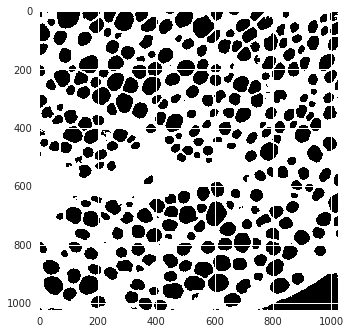

In [42]:
plt.imshow(cv2.imread(seg_masks[np.argmax([len(i) for i in measurements])],0))
plt.show()
